In [45]:
kernel = """
    __constant uchar sbox[] = {
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, 
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, 
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, 
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  
};

uint my_popcount(uint x) {
    uint count;
    for (count = 0; x; count++) {
        x &= x - 1;
    }
    return count;
}

float mean(float* X, int len) {
    float sum = 0;
    for (int i = 0; i < len; i++) {
        sum += X[i];
    }
    return sum / len;
}

float std_dev(float* X, float X_bar, int len) {
    float sum = 0;
    for (int i = 0; i < len; i++) {
        sum += (X[i] - X_bar) * (X[i] - X_bar);
    }
    return sqrt(sum); 
}


__kernel void attack(__global uchar* textin_array, __global float* trace_array, int trace_array_len, __global uchar* bestguess, __global float* cparefs)  {
    int bnum = get_global_id(0);
    int num_text_inputs = trace_array_len;
    float t_bar = 0.0, o_t = 0.0;
    float maxcpa = 0;
    uchar key_byte_guess = 0;
    float hws[50];
    float max_correlation = -1.0; 
    float correlation_array[TRACE_LENGTH];
    float o_t_array[TRACE_LENGTH];
    float t_bar_array[TRACE_LENGTH];
    
    // calc t_bar
    for (int j = 0; j < TRACE_LENGTH; j++) {
        float sum = 0;
        for (int i = 0; i < num_text_inputs; i++) {
            sum += trace_array[i * TRACE_LENGTH + j];
        }
        t_bar_array[j] = sum / num_text_inputs;
    }
    
    // calc o_t
    for (int j = 0; j < TRACE_LENGTH; j++) {
        float sum = 0;
        for (int i = 0; i < num_text_inputs; i++) {
            float diff = trace_array[i * TRACE_LENGTH + j] - t_bar_array[j];
            sum += diff * diff;
        }
        o_t_array[j] = sqrt(sum);
    }
    
    for (int kguess = 0; kguess < 256; kguess++) { 
        for (int i = 0; i < num_text_inputs; i++) {
                hws[i] = my_popcount(sbox[textin_array[i * 16 + bnum] ^ kguess]);
            }
            
        float hws_bar = mean(hws, num_text_inputs);
        float o_hws = std_dev(hws, hws_bar, num_text_inputs);
        
        for (int j = 0; j < TRACE_LENGTH; j++) {
            float sum = 0;
            for (int i = 0; i < num_text_inputs; i++) {
                float trace_diff = trace_array[i * TRACE_LENGTH + j] - t_bar_array[j];
                float hws_diff = hws[i] - hws_bar;
                sum += trace_diff * hws_diff;
            }
            correlation_array[j] = sum / (o_t_array[j] * o_hws);
            float correlation = fabs(correlation_array[j]);
            if (correlation > max_correlation) {
                max_correlation = correlation;
                key_byte_guess = kguess;
            }
        }
    }
    // Save the best guess and its correlation value in the output buffers
    bestguess[bnum] = key_byte_guess;
    cparefs[bnum] = max_correlation;
}
"""

In [69]:
import pyopencl as cl
from tqdm import tnrange
import numpy as np
import time
import matplotlib.pyplot as plt

trace_array = np.load(r"trace_array.npy").astype(np.float32)
textin_array = np.load(r"textin_array.npy")
key = np.load(r"traces/lab4_2_key.npy")
trace_array = trace_array[0:50]
textin_array = textin_array[0:50]

platforms = cl.get_platforms()
devices = platforms[0].get_devices()
ctx = cl.Context([devices[0]])
queue = cl.CommandQueue(ctx)
mf = cl.mem_flags

textin_array_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=textin_array)
bestguess_buf = cl.Buffer(ctx, mf.WRITE_ONLY, size=16 * np.dtype(np.uint8).itemsize)
cparefs_buf = cl.Buffer(ctx, mf.WRITE_ONLY, size=16 * np.dtype(np.float32).itemsize)

numsubkeys = 16
numtraces_part = 0

# Prepare to store chunk sizes and their respective execution times
chunk_sizes = []
execution_times = []

# List of fixed chunk sizes
fixed_chunk_sizes = [10, 50, 100, 500, 1000, 2500, 5000]  # Adjust as needed

for chunk_size in fixed_chunk_sizes:
    chunk_sizes.append(chunk_size)
    print(f"Processing chunk size {chunk_size}")
    assert trace_array.shape[1] % chunk_size == 0, "The number of columns in trace_array must be divisible by the chunk size."

    st = time.time()

    trace_array_chunks = np.split(trace_array, trace_array.shape[1]//chunk_size, axis=1)
    numtraces_part = trace_array.shape[0] //1
    
    TRACE_LENGTH = str(chunk_size)  

    # Build the program
    prg = cl.Program(ctx, kernel).build(options=['-D', f'TRACE_LENGTH='+TRACE_LENGTH])

    bestguess_all = np.empty((len(trace_array_chunks), numsubkeys), dtype=np.uint8)
    cparefs_all = np.empty((len(trace_array_chunks), numsubkeys), dtype=np.float32)

    for chunk_index, trace_array_part in enumerate(trace_array_chunks):
        
        trace_array_part_contig = np.ascontiguousarray(trace_array_part)

        trace_array_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=trace_array_part_contig)
        prg.attack(queue, (numsubkeys,), None, textin_array_buf, trace_array_buf, np.int32(numtraces_part), bestguess_buf, cparefs_buf)

        bestguess = np.empty(numsubkeys, dtype=np.uint8)
        cparefs = np.empty(numsubkeys, dtype=np.float32)
        cl.enqueue_copy(queue, bestguess, bestguess_buf)
        cl.enqueue_copy(queue, cparefs, cparefs_buf)

        bestguess_all[chunk_index] = bestguess
        cparefs_all[chunk_index] = cparefs

    best_indices = np.argmax(cparefs_all, axis=0)
    best_cparefs = np.array([cparefs_all[best_indices[i], i] for i in range(numsubkeys)])
    best_bestguess = np.array([bestguess_all[best_indices[i], i] for i in range(numsubkeys)])

        
    et = time.time()
    elapsed_time = et - st
    execution_times.append(elapsed_time)

Processing chunk size 10
Processing chunk size 50
Processing chunk size 100
Processing chunk size 500
Processing chunk size 1000
Processing chunk size 2500
Processing chunk size 5000


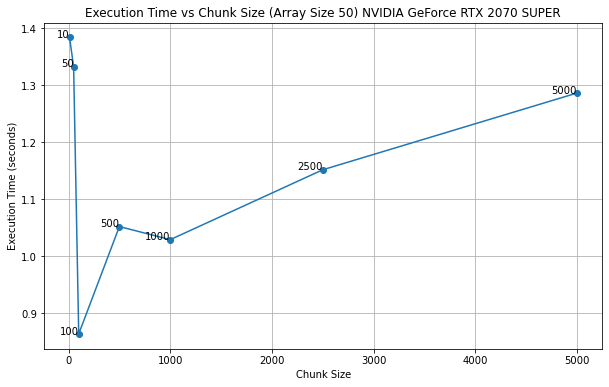

In [70]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(chunk_sizes, execution_times, 'o-')
plt.xlabel('Chunk Size')
plt.ylabel('Execution Time (seconds)')
plt.title(str('Execution Time vs Chunk Size (Array Size '+ str(numtraces_part)+') '+devices[0].name))
plt.grid(True)

# Annotate each point with its y-value (execution time)
for i in range(len(chunk_sizes)):
    plt.text(chunk_sizes[i], execution_times[i], f'{chunk_sizes[i]}', ha='right')
# save the plot as picture
plt.savefig('Execution_Time_Array_2_'+ str(numtraces_part)+'.png', dpi=300)
plt.show()

In [67]:
# Print the results for bestguess and cparefs
print("Best Key Guess:", end=" ")

for guess in best_bestguess:
    print(f"{guess:02x}", end=" ")
print("\n")

print("[", end="")
for i, cpa_ref in enumerate(best_cparefs):
    if i != len(best_cparefs) - 1:
        print(f"{cpa_ref:.6f}, ", end="")
    else:
        print(f"{cpa_ref:.6f}", end="")
print("]")

Best Key Guess: 2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c 

[0.946283, 0.902872, 0.876464, 0.897764, 0.967056, 0.893100, 0.839575, 0.862208, 0.915915, 0.913954, 0.909714, 0.860118, 0.906779, 0.888692, 0.919692, 0.928111]
